# Customer Churn Prediction

## `Telco_Customer_Churn`

**Content**

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
telco=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
telco.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# Although,TotalCharges should be numerical data type,but it is object type here.
telco.TotalCharges=pd.to_numeric(telco.TotalCharges,errors='coerce') #If 'coerce', then invalid parsing will be set as NaN.

In [6]:
def null_values(telco):
    nv=pd.concat([telco.isnull().sum(), 100 * telco.isnull().sum()/telco.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [7]:
null_values(telco)

,Missing_Records,Percentage (%)
TotalCharges,11,0.156183


In [8]:
telco.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
null_indexes=telco[telco.TotalCharges.isnull()].index
telco.loc[null_indexes,['tenure','MonthlyCharges','TotalCharges','Churn']]

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


In [10]:
# we can drop null values and customerID column.
telco=telco.fillna(0)
telco=telco.drop(['customerID'],axis=1)

In [11]:
telco['Churn_Rate']=telco['Churn'].map({"No":0,"Yes":1})

In [12]:
telco.rename(columns={"tenure": "Tenure", "gender": "Gender"},inplace=True)

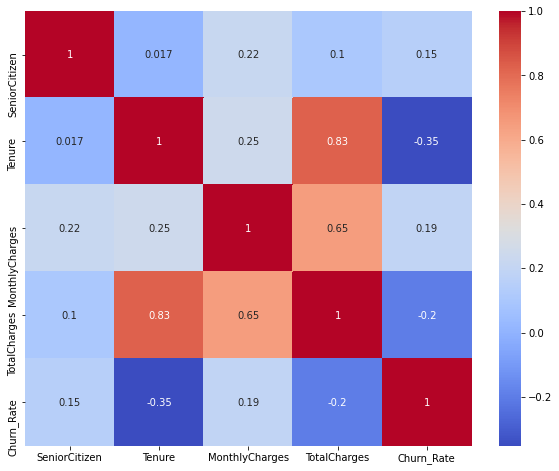

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(telco.corr(), cmap='coolwarm',annot=True);

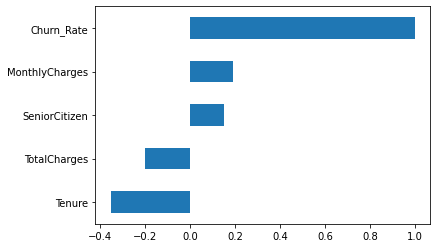

In [14]:
telco.corr()["Churn_Rate"].sort_values().plot.barh();

In [15]:
telco.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Churn_Rate
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [16]:
# categorik verilerin istatistiksel analizi icin:
telco.describe(include=['O'])

,Gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [17]:
# her columns in num of uniques
telco.apply(lambda x: x.nunique())

Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
Tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
Churn_Rate             2
dtype: int64

**Exploring the Data**

Our purpose here, mostly, understanding which and how variables are related to 'Churn'. Who wants to leave the telecom service company and why? So we made it 'Churn' oriented.

Customer churn is the loss of clients or customers.

In [18]:
print('Unique Values of Each Features:\n')
for i in telco:
    print(f'{i}:\n{sorted(telco[i].unique())}\n')

Unique Values of Each Features:

Gender:
['Female', 'Male']

SeniorCitizen:
[0, 1]

Partner:
['No', 'Yes']

Dependents:
['No', 'Yes']

Tenure:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]

PhoneService:
['No', 'Yes']

MultipleLines:
['No', 'No phone service', 'Yes']

InternetService:
['DSL', 'Fiber optic', 'No']

OnlineSecurity:
['No', 'No internet service', 'Yes']

OnlineBackup:
['No', 'No internet service', 'Yes']

DeviceProtection:
['No', 'No internet service', 'Yes']

TechSupport:
['No', 'No internet service', 'Yes']

StreamingTV:
['No', 'No internet service', 'Yes']

StreamingMovies:
['No', 'No internet service', 'Yes']

Contract:
['Month-to-month', 'One year', 'Two year']

PaperlessBilling:
['No', 'Yes']

PaymentMethod:
['Bank transfer (automatic

In [19]:
telco.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [20]:
def perc_col(df,col):
    for i in sorted(df[col].unique(),reverse=True):
        print('%s: %%%.2f' % (i, 100*df[col].value_counts()[i]/len(df)))

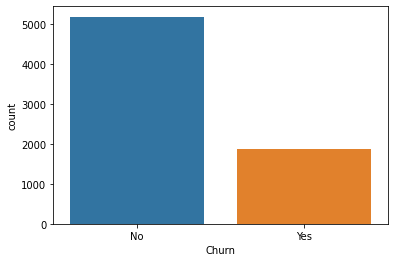

{'No': 5174, 'Yes': 1869}

Customer Attrition Ratio:
Yes: %26.54
No: %73.46


In [21]:
sns.countplot(x='Churn',data=telco)
plt.show()

print(dict(Counter(telco['Churn'])))
print('\nCustomer Attrition Ratio:')
perc_col(telco,'Churn')

### Gender - Partner 

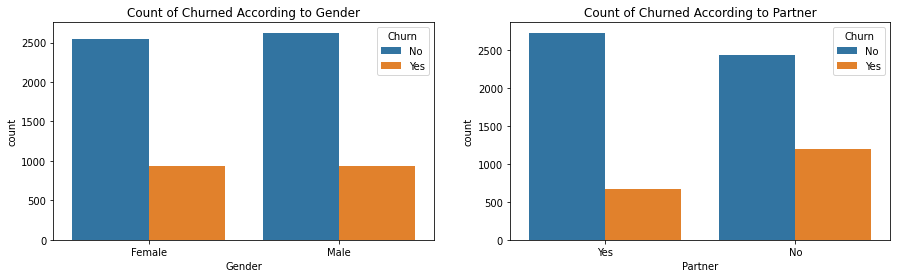

Churn:'Yes'
Gender: {'Male': 930, 'Female': 939}
Partner: {'No': 1200, 'Yes': 669}

Churn:'No'
Gender: {'Female': 2549, 'Male': 2625}
Partner: {'Yes': 2733, 'No': 2441}


In [22]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title("Count of Churned According to Gender")
sns.countplot(x='Gender', data=telco, hue='Churn')
plt.subplot(122)
plt.title("Count of Churned According to Partner")
sns.countplot(x='Partner', data=telco, hue='Churn')
plt.show()

print("Churn:'Yes'\n",
      'Gender: ',dict(Counter(telco[telco.Churn=='Yes']['Gender'])),
      '\nPartner: ',dict(Counter(telco[telco.Churn=='Yes']['Partner'])),
     "\n\nChurn:'No'\n",
      'Gender: ',dict(Counter(telco[telco.Churn=='No']['Gender'])),
     '\nPartner: ',dict(Counter(telco[telco.Churn=='No']['Partner'])),sep='')

> **`Gender` is ineffective for prediction of customer churn.**

### Phone Service - Streaming TV - MultipleLines

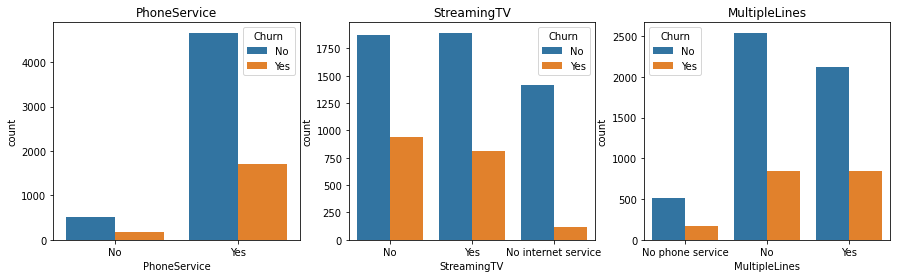

In [23]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title("PhoneService")
sns.countplot(x='PhoneService',hue='Churn',data=telco)
plt.subplot(132)
plt.title("StreamingTV")
sns.countplot(x='StreamingTV',hue='Churn',data=telco)
plt.subplot(133)
plt.title("MultipleLines")
sns.countplot(x='MultipleLines',hue='Churn',data=telco)
plt.show()

> **Whether customer have `Phone Service` not does not seem to have an effect on the churn.**

### Online Security - Tech Support

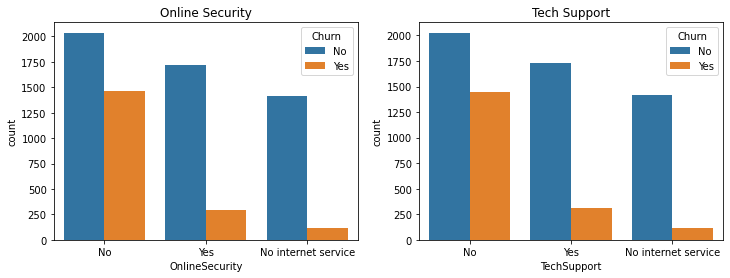

Churn Ratios by Online Security 

No                     41.77
Yes                    14.61
No internet service     7.40
Name: OnlineSecurity, dtype: float64

Churn Ratios by Tech Support 

No                     41.64
Yes                    15.17
No internet service     7.40
Name: TechSupport, dtype: float64


In [24]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Online Security")
sns.countplot(x = 'OnlineSecurity', hue = 'Churn', data = telco)
plt.subplot(122)
plt.title("Tech Support")
sns.countplot(x = 'TechSupport', hue = 'Churn', data = telco)
plt.show()

print('Churn Ratios by Online Security','\n')
print(round(telco[telco['Churn']=='Yes']['OnlineSecurity'].value_counts() / telco['OnlineSecurity'].value_counts()*100,2))

print('\nChurn Ratios by Tech Support','\n')
print(round(telco[telco['Churn']=='Yes']['TechSupport'].value_counts() / telco['TechSupport'].value_counts()*100,2))

> **Customers who did not sign up for `OnlineSecurity` and `TechSupport` are most likely to churn.**

### Tenure

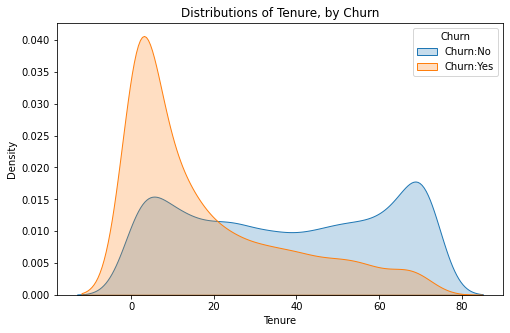

Average Tenure of Churned Customers: 18 
Average Tenure of Not-Churned Customers: 38


In [25]:
churn_tenure=telco[telco.Churn=='Yes']['Tenure']
not_churn_tenure=telco[telco.Churn=='No']['Tenure']

plt.figure(figsize=(8,5))
sns.kdeplot(data=not_churn_tenure, shade=True)
sns.kdeplot(data=churn_tenure, shade=True)
plt.legend(("Churn:No", "Churn:Yes"),title='Churn')
plt.title("Distributions of Tenure, by Churn")

plt.show()

print('Average Tenure of Churned Customers:',round(churn_tenure.mean()),
      '\nAverage Tenure of Not-Churned Customers:',round(not_churn_tenure.mean()))

> **Not churned customers have a much longer average tenure (20 months) than the churned customers.**

### Monthly Charges

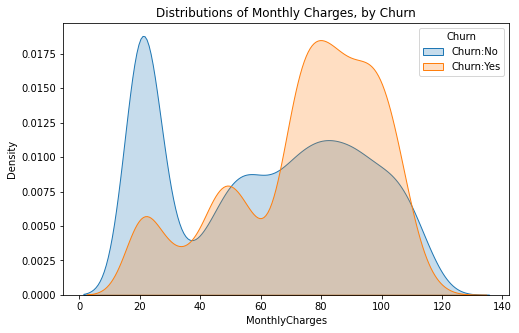

Average Monthly Fee of Churned Customers: 74 
Average Monthly Fee of Not-Churned Customers: 61


In [26]:
churn_mcharge=telco[telco.Churn=='Yes']['MonthlyCharges']
not_churn_mcharge=telco[telco.Churn=='No']['MonthlyCharges']
plt.figure(figsize=(8,5))

sns.kdeplot(data=not_churn_mcharge,shade=True)
sns.kdeplot(data=churn_mcharge,shade=True)
plt.legend(("Churn:No", "Churn:Yes"),title='Churn')
plt.title("Distributions of Monthly Charges, by Churn")
plt.show()

print('Average Monthly Fee of Churned Customers:',round(churn_mcharge.mean()),
      '\nAverage Monthly Fee of Not-Churned Customers:',round(not_churn_mcharge.mean()))

> **Churned customers paid over 20% higher on average monthly fee than not-churned customers.**

### Deal with Outliers

In [27]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [28]:
categorical=telco.select_dtypes(include='object').columns.tolist()
numeric=telco.dtypes[telco.dtypes!=object].keys().tolist() # result of dtypes is Series, so we use keys(), not columns
print('Categorical Features:',categorical,'\nNumerical Features:',numeric,sep='\n')

Categorical Features:
['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Numerical Features:
['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Rate']


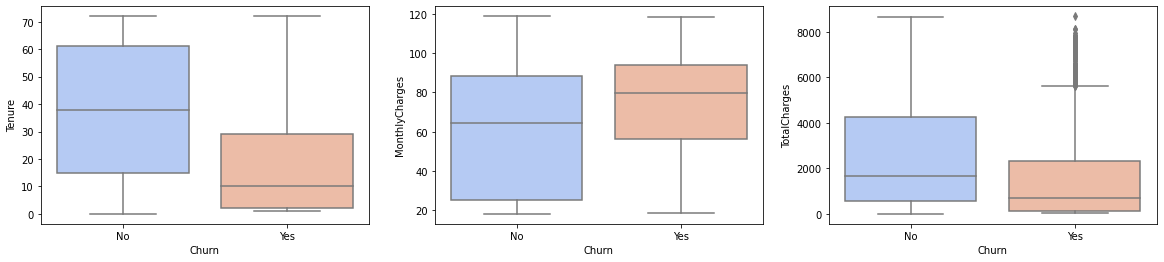

In [29]:
plt.figure(figsize=(20,4))
plt.subplot(131)
sns.boxplot(x='Churn', y='Tenure', data=telco, palette="coolwarm",whis=1.6)
plt.subplot(132)
sns.boxplot(x='Churn', y='MonthlyCharges', data=telco, palette="coolwarm")
plt.subplot(133)
sns.boxplot(x='Churn', y='TotalCharges', data=telco, palette="coolwarm")
plt.show()

**'TotalCharges' has some outliers. We can use root square for outliers.**

In [30]:
f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))
telco.TotalCharges=telco.TotalCharges.apply(f)

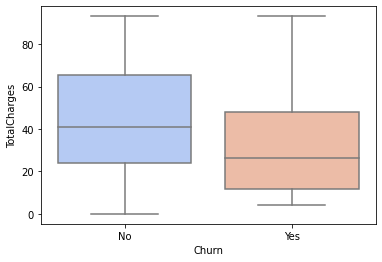

In [31]:
sns.boxplot(x='Churn', y='TotalCharges', data=telco, palette="coolwarm");

### Senior Citizen-Tenure-Monthly Charges

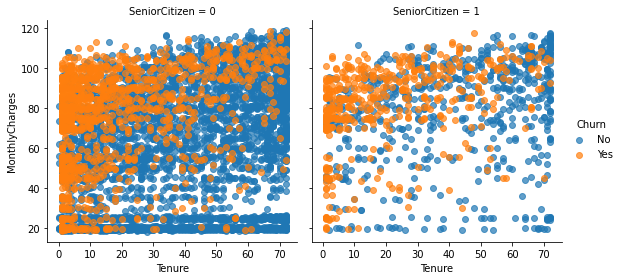

In [32]:
g=sns.FacetGrid(telco,col='SeniorCitizen', hue='Churn',height=4)
g.map(plt.scatter, 'Tenure', 'MonthlyCharges', alpha=0.7)
g.add_legend();

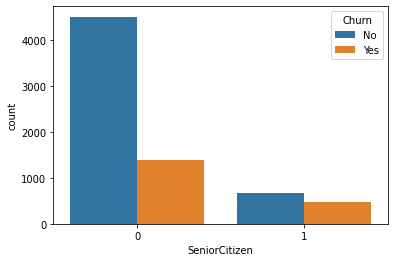

SeniorCitizens percentage of customers: % 16.21
SeniorCitizens churn rate: % 41.68
non-SeniorCitizens churn rate: % 23.61


In [33]:
plt.figure(figsize=(6,4))
sns.countplot(x='SeniorCitizen', data=telco, hue='Churn')
plt.show()

print('SeniorCitizens percentage of customers: % {:.2f}'.format(len(telco[telco.SeniorCitizen==1])/len(telco.SeniorCitizen)*100))
print('SeniorCitizens churn rate: % {:.2f}'.format(len(telco[(telco.SeniorCitizen==1) & (telco.Churn=='Yes')])/len(telco[telco.SeniorCitizen==1])*100))
print('non-SeniorCitizens churn rate: % {:.2f}'.format(len(telco[(telco.SeniorCitizen==0) & (telco.Churn=='Yes')])/len(telco[telco.SeniorCitizen==0])*100))

> **SeniorCitizens are only 16% of customers, but they have a much higher churn rate: 42% against 23% for non-senior customers.**

### Contract-Internet Service-Churn

In [34]:
telco.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [35]:
telco.InternetService.value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

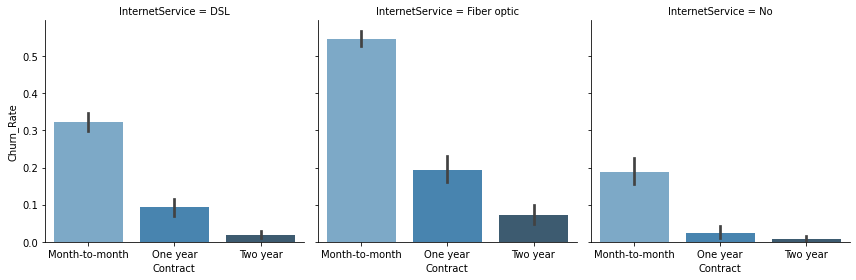

In [36]:
g = sns.FacetGrid(telco,col='InternetService',height=4)
ax = g.map(sns.barplot, "Contract", "Churn_Rate", palette = "Blues_d", order= telco.Contract.unique())

> **Short term contracts have higher churn rates. It is obvious that contract term does have an effect on churn.There were very few churns when customers have a two-year contract. And most churns occurred on customers with a month-to-month contract.**

> **It seems customers who signed up for Fiber optic are most likely to churn.**

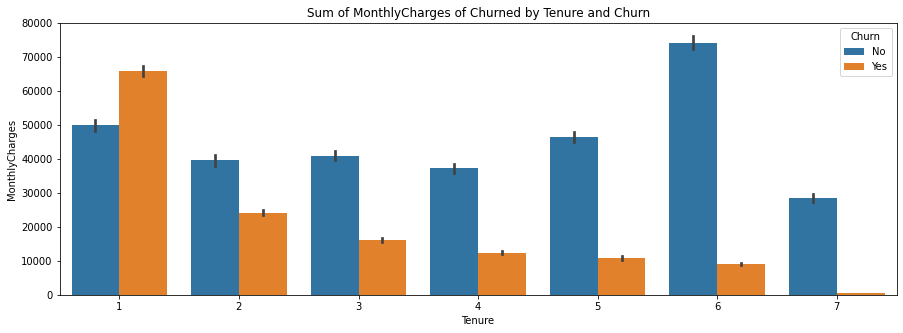

In [37]:
plt.figure(figsize=(15,5))
sns.barplot(x=telco.Tenure//12+1,y='MonthlyCharges',data=telco,hue='Churn',estimator=np.sum) #tenure with year
plt.title("Sum of MonthlyCharges of Churned by Tenure and Churn")
plt.show()

In [38]:
print('Average MonthlyCharges of Churned by Tenure:',
      telco.groupby([telco.Tenure//12+1,'Churn']).MonthlyCharges.mean(),sep='\n\n')

Average MonthlyCharges of Churned by Tenure:

Tenure  Churn
1       No       46.689346
        Yes      66.088388
2       No       53.617751
        Yes      78.134304
3       No       59.867862
        Yes      83.742228
4       No       61.913372
        Yes      85.056507
5       No       66.560402
        Yes      87.725203
6       No       72.250389
        Yes      96.915054
7       No       80.423174
        Yes      96.875000
Name: MonthlyCharges, dtype: float64


In [39]:
print('Sum of Churned Count by Tenure:',
      telco.groupby([telco.Tenure//12+1,'Churn']).MonthlyCharges.count(),sep='\n\n')

Sum of Churned Count by Tenure:

Tenure  Churn
1       No       1070
        Yes       999
2       No        738
        Yes       309
3       No        683
        Yes       193
4       No        602
        Yes       146
5       No        697
        Yes       123
6       No       1028
        Yes        93
7       No        356
        Yes         6
Name: MonthlyCharges, dtype: int64


> **In first year, count of the Churned and Not Churned are close to each other. In the later years,the Not Churned customers are more than Churned customers.**

### Transform to Dummy and Drop Categorical Features

In [40]:
telco.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Rate
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,5.463515,No,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,43.468379,No,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,10.399519,Yes,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,42.903963,No,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,12.314625,Yes,1


In [41]:
telco['Churn']=telco['Churn'].map({"No":0,"Yes":1})
telco.drop(columns=['Churn_Rate'],axis=1,inplace=True)

In [42]:
telco=pd.get_dummies(telco,drop_first=True)
telco.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Churn,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,5.463515,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,43.468379,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,10.399519,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,42.903963,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,12.314625,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [43]:
telco.isnull().sum().any()

False

In [44]:
telco.to_csv("telco_clean_20201215.csv", index = False)